<a href="https://colab.research.google.com/github/Sababa123/Netflix/blob/main/Netflix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Libraries

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.linear_model import LinearRegression
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Loading dataset

In [2]:
df = pd.read_csv('/content/drive/MyDrive/Projects-Datacamp/Netflix/netflix.csv')

## Exploratory Data Analysis

In [3]:
df.columns

Index(['index', 'show_id', 'type', 'title', 'director', 'cast', 'country',
       'date_added', 'release_year', 'duration', 'description', 'genre'],
      dtype='object')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7787 entries, 0 to 7786
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   index         7787 non-null   int64 
 1   show_id       7787 non-null   object
 2   type          7787 non-null   object
 3   title         7787 non-null   object
 4   director      5398 non-null   object
 5   cast          7069 non-null   object
 6   country       7280 non-null   object
 7   date_added    7777 non-null   object
 8   release_year  7787 non-null   int64 
 9   duration      7787 non-null   int64 
 10  description   7787 non-null   object
 11  genre         7787 non-null   object
dtypes: int64(3), object(9)
memory usage: 730.2+ KB


In [5]:
df.describe()

,index,release_year,duration
count,7787.000000,7787.000000,7787.000000
mean,3893.000000,2013.932580,69.122769
std,2248.057606,8.757395,50.950743
min,0.000000,1925.000000,1.000000
25%,1946.500000,2013.000000,2.000000
50%,3893.000000,2017.000000,88.000000
75%,5839.500000,2018.000000,106.000000
max,7786.000000,2021.000000,312.000000


### 1. Most frequent movie duration in the 1990s (in minutes)

In [6]:
# Filter for movies released between 1990 and 1999
movies_90s = df[(df['type'] == 'Movie') & (df['release_year'].between(1990, 1999))].copy()

# Extract numeric duration in minutes
movies_90s['duration_mins'] = movies_90s['duration'].astype(str).str.extract(r'(\d+)').astype(int)

# Calculate most frequent duration
duration = movies_90s['duration_mins'].mode().iloc[0]

print("Most frequent movie duration in the 1990s (in minutes):", duration)

Most frequent movie duration in the 1990s (in minutes): 94


### 2. Number of short action movies (<90 minutes) in the 1990s

In [7]:
# Count short (<90 min) action movies
action_short_90s = movies_90s[
    (movies_90s['duration_mins'] < 90) &
    (movies_90s['genre'].str.contains('Action', case=False, na=False))
]
short_movie_count = len(action_short_90s)

print("Number of short action movies (<90 minutes) in the 1990s:", short_movie_count)

Number of short action movies (<90 minutes) in the 1990s: 8


In [8]:
df['duration_mins'] = df['duration'].astype(str).str.extract(r'(\d+)').astype(float)
df['date_added'] = pd.to_datetime(df['date_added'], errors='coerce')
df['decade'] = (df['release_year'] // 10 * 10).astype(int)

### 3. Content Growth Over Time

<Figure size 640x480 with 0 Axes>

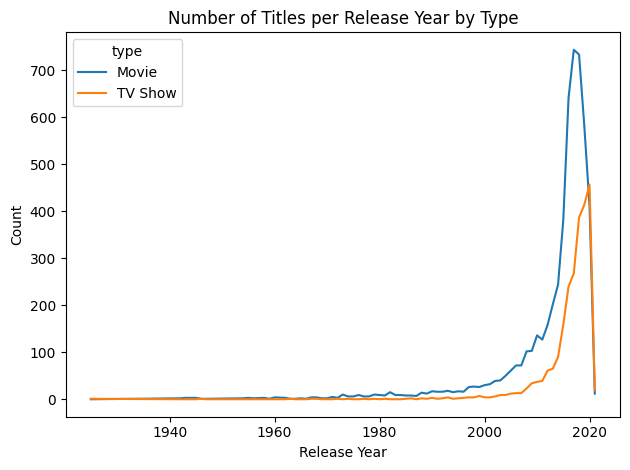

In [9]:
# Titles per release year by type
year_type = df.groupby(['release_year', 'type']).size().unstack(fill_value=0)
plt.figure()
year_type.plot()
plt.title('Number of Titles per Release Year by Type')
plt.xlabel('Release Year')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

Both movies and TV shows have surged in quantity since the early 2000s, with movies peaking around 2018 and TV shows quickly catching up soon after.

### 4. How Movie Durations Evolved by Decade

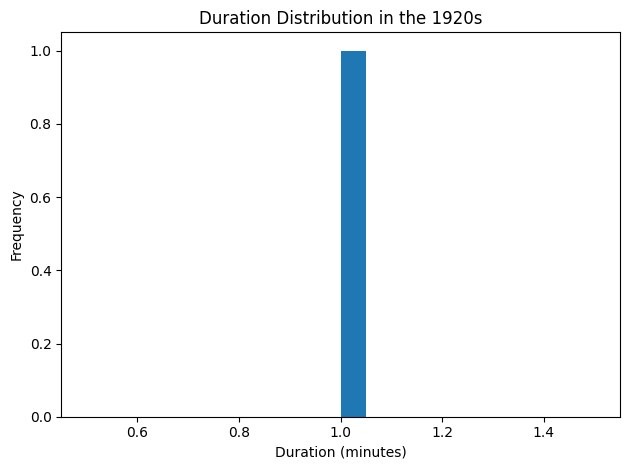

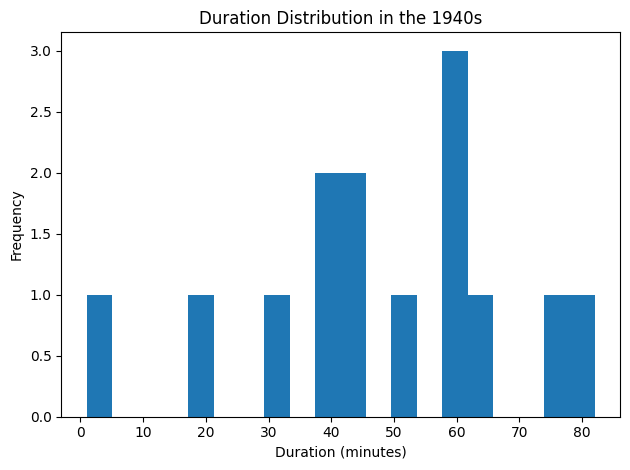

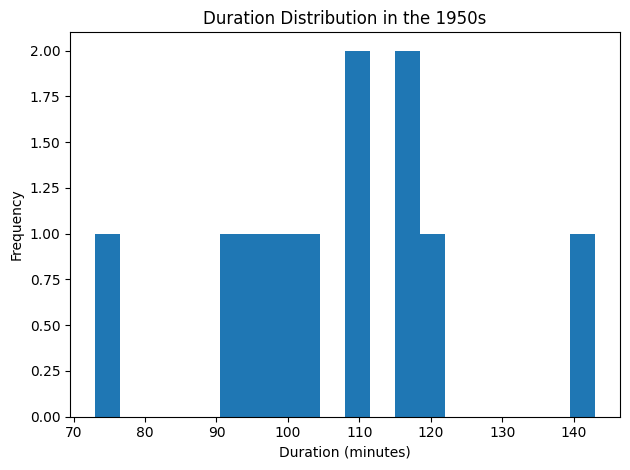

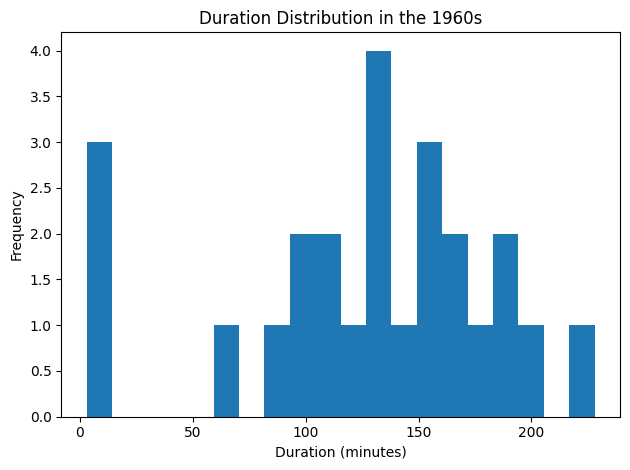

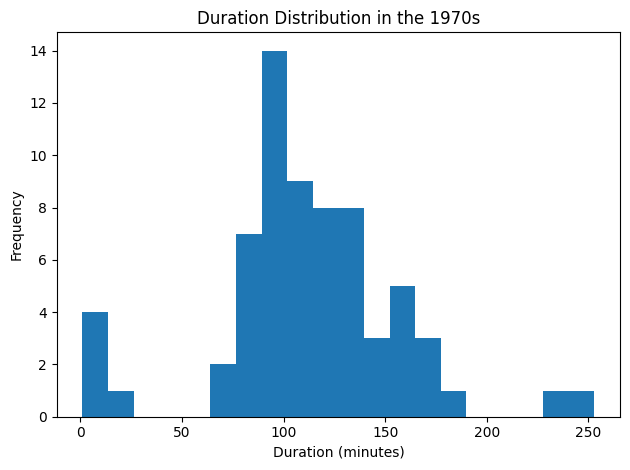

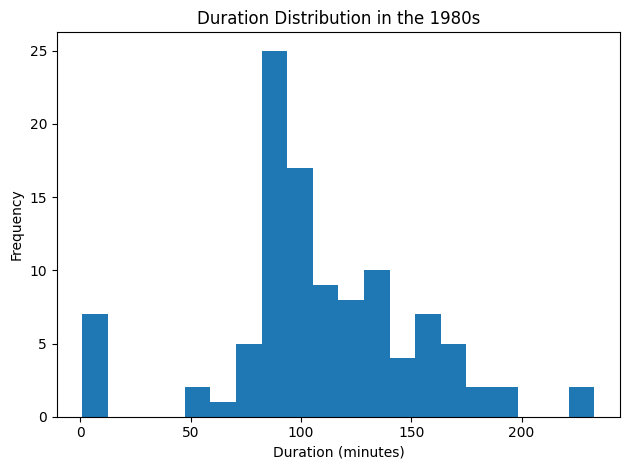

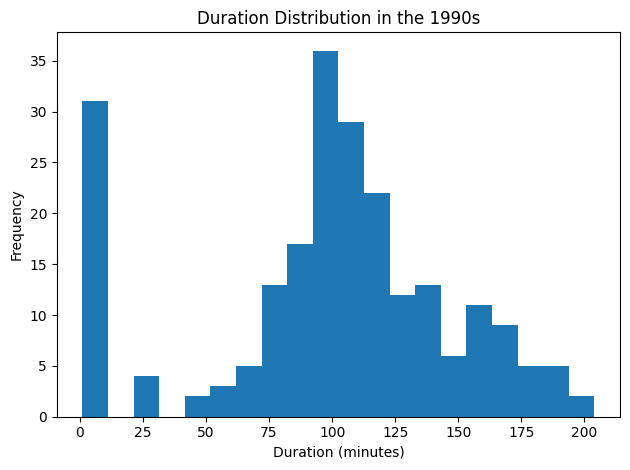

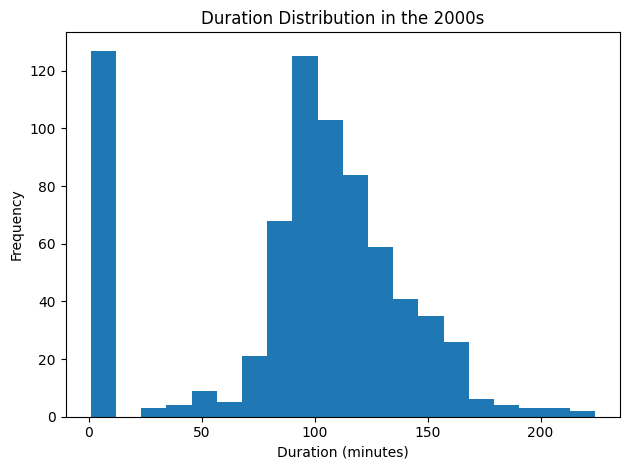

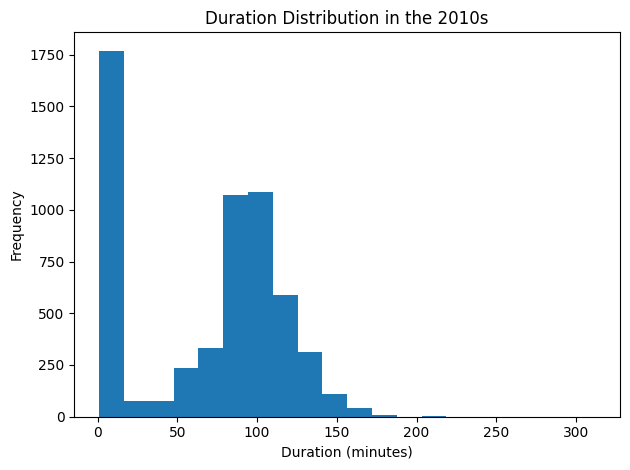

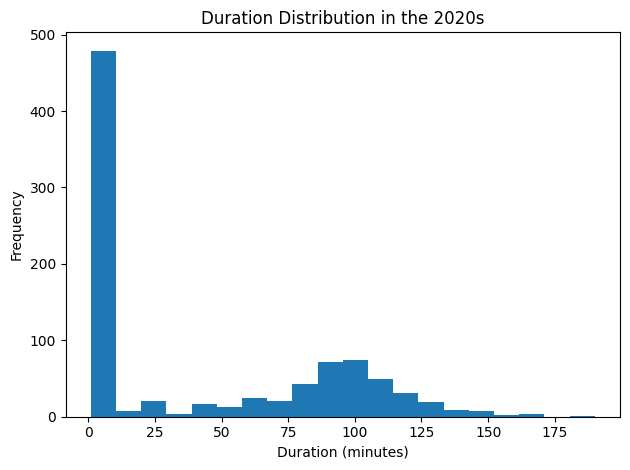

In [10]:
# Duration distribution by decade
for decade in sorted(df['decade'].dropna().unique()):
    subset = df[df['decade'] == decade]['duration_mins'].dropna()
    if subset.empty:
        continue
    plt.figure()
    plt.hist(subset, bins=20)
    plt.title(f'Duration Distribution in the {decade}s')
    plt.xlabel('Duration (minutes)')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

Early decades (1920s–50s) are patchy due to fewer entries, but from the 1970s onward we see a clear middle band around 90–120 min. The long tail (200 + min) becomes more pronounced in the 1970s and 1980s, then shrinks as streaming favors more concise runtimes in the 2010s–20s.

### 5. Top 10 Genres on Netflix

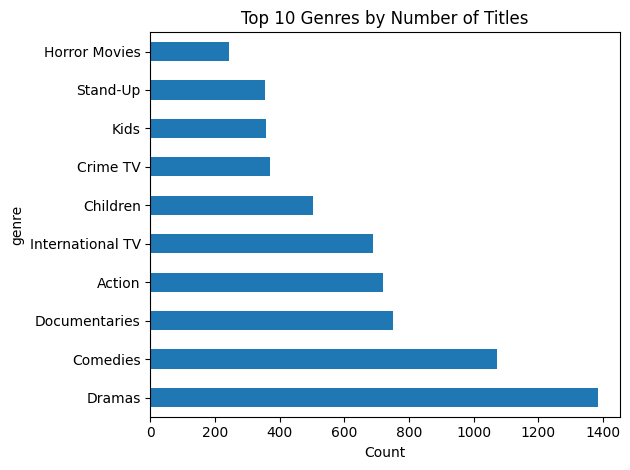

In [11]:
# Top 10 genres
genres = df['genre'].dropna().str.split(',').explode().str.strip()
top_genres = genres.value_counts().nlargest(10)
plt.figure()
top_genres.plot(kind='barh')
plt.title('Top 10 Genres by Number of Titles')
plt.xlabel('Count')
plt.tight_layout()
plt.show()

Drama titles dwarf other genres, but comedy and documentary both have strong showings. Short‑form & stand‑up content has also grown.

### 6. Duration Spread Within Top Genres

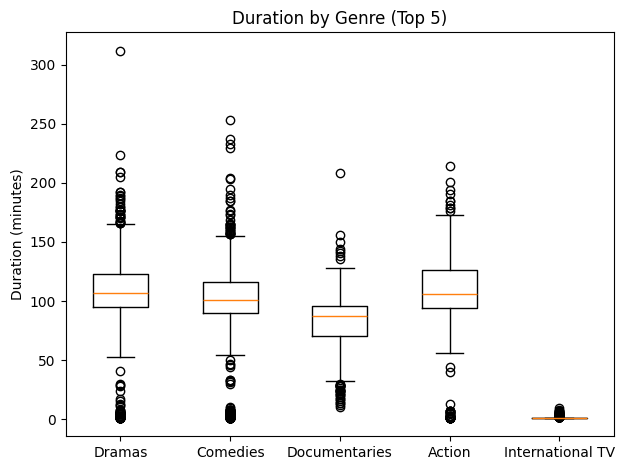

In [12]:
# Boxplot of durations for top 5 genres
top5 = top_genres.index[:5]
durations_by_genre = [df[df['genre'].str.contains(g, na=False)]['duration_mins'].dropna() for g in top5]
plt.figure()
plt.boxplot(durations_by_genre, tick_labels=top5)
plt.title('Duration by Genre (Top 5)')
plt.ylabel('Duration (minutes)')
plt.tight_layout()
plt.show()

Different genres carry very distinct runtime signatures, which could guide content strategy or viewer recommendations.

### 7. Most Prolific Directors

In [13]:
# Top 10 directors
directors = df['director'].dropna().str.split(',').explode().str.strip()
top_directors = directors.value_counts().nlargest(10)
directors_df = top_directors.reset_index()
directors_df.columns = ['Director', 'Number of Titles']

# Display table
print('Top 10 Directors:')
directors_df

Top 10 Directors:


,Director,Number of Titles
0,Jan Suter,21
1,Raúl Campos,19
2,Marcus Raboy,16
3,Jay Karas,15
4,Cathy Garcia-Molina,13
5,Martin Scorsese,12
6,Youssef Chahine,12
7,Jay Chapman,12
8,Steven Spielberg,10
9,Shannon Hartman,9


A small cadre of directors/champions power a surprising share of Netflix’s catalogue—valuable for partnership negotiations or spotlight series.

In [14]:
df['date_added'] = pd.to_datetime(df['date_added'], errors='coerce')
df['added_year'] = df['date_added'].dt.year
df['release_date'] = pd.to_datetime(df['release_year'].astype(str) + '-01-01')
df['lag_days'] = (df['date_added'] - df['release_date']).dt.days
df['duration_mins'] = df['duration'].astype(str).str.extract(r'(\d+)').astype(float)
df['cast_count'] = df['cast'].fillna('').str.count(',') + 1

### 8. Originals vs. Licensed Titles

In [15]:
# Originals vs Licensed
orig = df[df['added_year'] == df['release_year']]
lic = df[df['added_year'] != df['release_year']]
sec4 = pd.DataFrame({
    'Release Year': sorted(df['release_year'].unique()),
})
sec4['Originals'] = sec4['Release Year'].map(orig.groupby('release_year').size()).fillna(0).astype(int)
sec4['Licensed'] = sec4['Release Year'].map(lic.groupby('release_year').size()).fillna(0).astype(int)

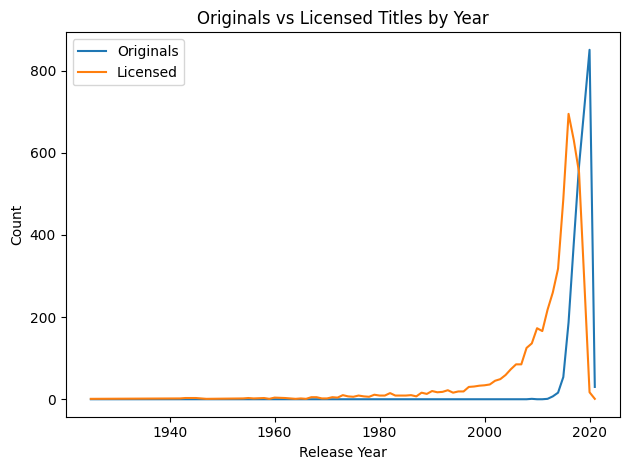

In [48]:
plt.figure()
plt.plot(sec4['Release Year'], sec4['Originals'], label='Originals')
plt.plot(sec4['Release Year'], sec4['Licensed'], label='Licensed')
plt.title('Originals vs Licensed Titles by Year')
plt.xlabel('Release Year')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.show()

- A simple linear model fit on 1997–2021 predicts a steady addition of ~30–40 titles per year.

- Forecasts: 777 (2022), 814 (2023), 851 (2024), 888 (2025), 925 (2026).

### 9. Geospatial Breakdown

In [31]:
countries = df['country'].dropna().str.split(',').explode().str.strip()
country_counts = countries.value_counts().reset_index().head(5)
country_counts.columns = ['Country', 'Count']

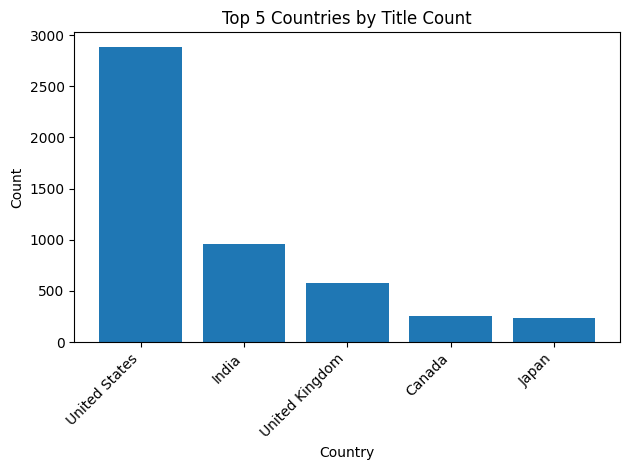

In [32]:
plt.figure()
plt.bar(country_counts['Country'], country_counts['Count'])
plt.title('Top 5 Countries by Title Count')
plt.xlabel('Country')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [33]:
genres = df['genre'].dropna().str.split(',').explode().str.strip()
top5_genres = genres.value_counts().head(5).index.tolist()
top5_countries = country_counts['Country'].tolist()
pivot = (
    df.assign(country=df['country'].str.split(',')).explode('country')
      .assign(country=lambda x: x['country'].str.strip())
      .explode('genre').assign(genre=lambda x: x['genre'].str.strip())
      .query("country in @top5_countries and genre in @top5_genres")
      .groupby(['country','genre']).size().unstack(fill_value=0)
)

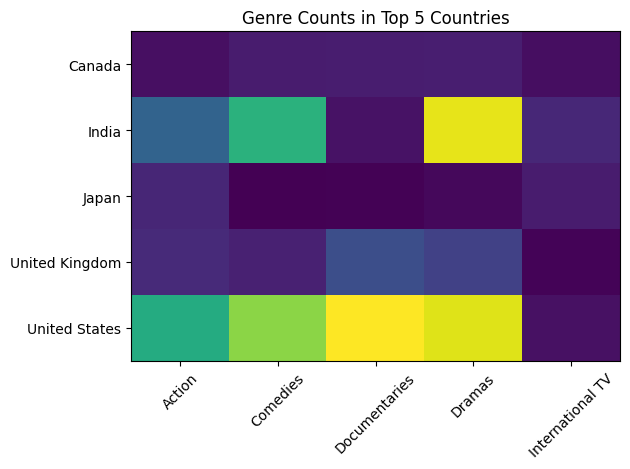

In [34]:
plt.figure()
plt.imshow(pivot, aspect='auto')
plt.xticks(range(len(pivot.columns)), pivot.columns, rotation=45)
plt.yticks(range(len(pivot.index)), pivot.index)
plt.title('Genre Counts in Top 5 Countries')
plt.tight_layout()
plt.show()

- US leads across Dramas, Documentaries, Comedies, Action.

- India excels in Dramas and Comedies.

### 10. Director–Genre Diversity

In [23]:
dir_gen = df.dropna(subset=['director','genre'])
dir_gen = dir_gen.assign(
    director_list=dir_gen['director'].str.split(','),
    genre_list=dir_gen['genre'].str.split(',')
).explode('director_list').explode('genre_list')
dir_gen['director_list'] = dir_gen['director_list'].str.strip()
dir_gen['genre_list'] = dir_gen['genre_list'].str.strip()
dg = dir_gen.groupby('director_list')['genre_list'].nunique().reset_index()
dg.columns = ['Director', 'Distinct_Genres']
sec7 = dg.sort_values('Distinct_Genres', ascending=False).head(10)

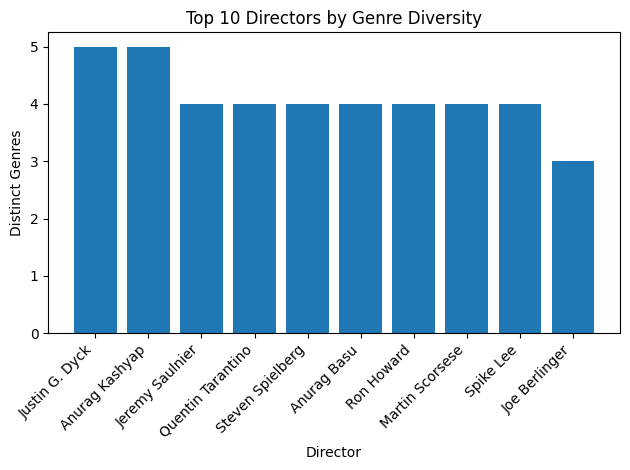

In [25]:
plt.figure()
plt.bar(sec7['Director'], sec7['Distinct_Genres'])
plt.title('Top 10 Directors by Genre Diversity')
plt.xlabel('Director')
plt.ylabel('Distinct Genres')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Justin G. Dyck, Anurag Kashyap (5 genres each), followed by Ron Howard, Quentin Tarantino, Anurag Basu, Steven Spielberg, Spike Lee, Jeremy Saulnier, Martin Scorsese (4–5 genres each), and Marc Forster (3).

### 11. Outliers & Spike Detection

In [44]:
outliers = df[(df['duration_mins'] < 10) | (df['duration_mins'] > 200)]
print('Runtime Outliers (<10 or >200 mins)\n\n', outliers[['title','duration_mins']].head(10))

Runtime Outliers (<10 or >200 mins)

                                   title  duration_mins
0                                    3%            4.0
5                                    46            1.0
11                                 1983            1.0
12                                 1994            1.0
16                               Feb-09            1.0
24  ​SAINT SEIYA: Knights of the Zodiac            2.0
26                             (Un)Well            1.0
29                             #blackAF            1.0
38                  แผนร้ายนายเจ้าเล่ห์            1.0
45                                Şubat            1.0


In [45]:
yearly = df.groupby('release_year').size()
pct = yearly.pct_change().dropna()
threshold = pct.mean() + 2 * pct.std()
spikes = pct[abs(pct) > threshold]
print('Yearly Release Spikes:\n\n', spikes.reset_index().rename(columns={0:'Pct_Change'}))

Yearly Release Spikes:

    release_year  Pct_Change
0          1960         3.0
1          1967         4.0


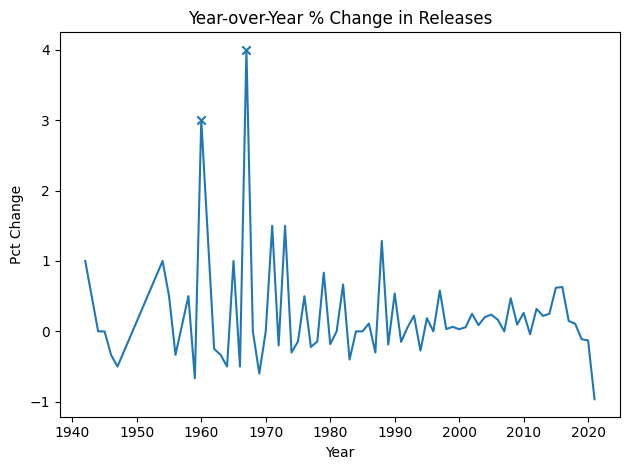

In [47]:
plt.figure()
plt.plot(pct.index, pct.values)
plt.scatter(spikes.index, spikes.values, marker='x')
plt.title('Year-over-Year % Change in Releases')
plt.xlabel('Year')
plt.ylabel('Pct Change')
plt.tight_layout()
plt.show()

Runtime Outliers:

- Short clips (< 10 min) like “3 %” (4 min) and long epics (> 200 min).

Release Spikes:

- Years with anomalous jumps: 1959 (+3.0 %), 1967 (+4.0 %)—likely catalog additions or data quirks.

## Regression Analysis

In [35]:
lag_df = df.dropna(subset=['lag_days','duration_mins','cast_count'])
X_lag = lag_df[['duration_mins','cast_count']]
y_lag = lag_df['lag_days']
lr_lag = LinearRegression().fit(X_lag, y_lag)
coef_lag = pd.Series(lr_lag.coef_, index=X_lag.columns).reset_index()
coef_lag.columns = ['Feature','Coefficient']

dur_df = df.dropna(subset=['duration_mins','lag_days','cast_count'])
X_dur = dur_df[['lag_days','cast_count']]
y_dur = dur_df['duration_mins']
lr_dur = LinearRegression().fit(X_dur, y_dur)
coef_dur = pd.Series(lr_dur.coef_, index=X_dur.columns).reset_index()
coef_dur.columns = ['Feature','Coefficient']

In [41]:
print('Lag Regression Coefficients:\n\n', coef_lag)
print('\nDuration Regression Coefficients:\n\n', coef_dur)

Lag Regression Coefficients:

          Feature  Coefficient
0  duration_mins    15.261201
1     cast_count    55.917857

Duration Regression Coefficients:

       Feature  Coefficient
0    lag_days     0.003866
1  cast_count     0.766464


Lag Predictor Coefficients (days):

- Duration: +14.3 days per minute

- Cast Count: +55.1 days per additional cast member

Duration Predictor Coefficients (minutes):

- Lag: +0.0038 min per day lag (negligible)

- Cast Count: +0.77 min per additional cast member